In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# 1. Data Collection and Preprocessing

In [2]:
df=pd.read_csv('ASIANPAINT.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-08,1219.000000,1224.000000,1205.000000,1209.900024,1177.812134,627060
1,2018-05-09,1197.599976,1229.099976,1197.599976,1222.550049,1190.126587,729538
2,2018-05-10,1232.000000,1238.000000,1207.500000,1217.699951,1185.405029,1904962
3,2018-05-11,1237.000000,1291.900024,1229.849976,1286.449951,1252.331787,4723019
4,2018-05-14,1285.000000,1305.000000,1268.599976,1297.349976,1262.942749,1553283


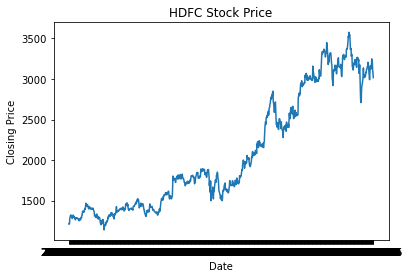

In [3]:
plt.plot(df['Date'],df['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("HDFC Stock Price")
plt.show()

In [4]:
ASAIN_close=df['Close']

In [5]:
len(ASAIN_close)

987

In [6]:
ASAIN_close.shape

(987,)

In [7]:
ASAIN_close=pd.DataFrame(ASAIN_close)

In [8]:
ASAIN_close

,Close
0,1209.900024
1,1222.550049
2,1217.699951
3,1286.449951
4,1297.349976
...,...
982,3237.199951
983,3200.000000
984,3100.850098
985,3076.550049


In [9]:
train_length=int(0.8*len(ASAIN_close))
ASAIN_train=ASAIN_close.iloc[:train_length]
ASAIN_test=ASAIN_close.iloc[train_length:]
len(ASAIN_train)+len(ASAIN_test)

987

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaler.fit(ASAIN_train)

MinMaxScaler()

In [12]:
scaled_train=scaler.transform(ASAIN_train)
scaled_test=scaler.transform(ASAIN_test)
scaled_train=scaled_train.reshape(len(scaled_train),1)
scaled_test=scaled_test.reshape(len(scaled_test),1)

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
length=20
batch_size=10

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=20)

features=1

generator= TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

validation_generator= TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch_size)

In [16]:
model= Sequential()

model.add(LSTM(50,input_shape=(length,features)))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit_generator(generator, steps_per_epoch=len(generator),validation_data=validation_generator,epochs=100,callbacks=[early_stop],shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
77/77 [==============================] - 5s 60ms/step - loss: 0.0048 - val_loss: 0.0109
Epoch 2/100
77/77 [==============================] - 4s 47ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 3/100
77/77 [==============================] - 3s 45ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 4/100
77/77 [==============================] - 5s 70ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 5/100
77/77 [==============================] - 6s 76ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 6/100
77/77 [==============================] - 5s 66ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 7/100
77/77 [==============================] - 7s 87ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 8/100
77/77 [==============================] - 4s 58ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 9/100
77/77 [==============================] - 7s 90ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 10/100
77/77 [====

<AxesSubplot:>

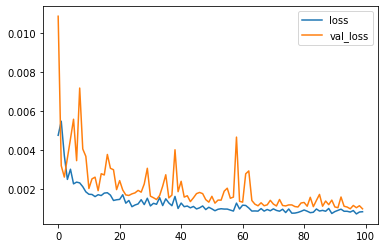

In [18]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [19]:
first_eval_batch=scaled_train[-length:]
len(first_eval_batch)
first_eval_batch

array([[1.        ],
       [0.97007927],
       [0.95792967],
       [0.98689185],
       [0.96650425],
       [0.95564992],
       [0.96526084],
       [0.96070147],
       [0.97567486],
       [0.96707422],
       [0.9721517 ],
       [0.96577895],
       [0.98525986],
       [0.97914616],
       [0.96997568],
       [0.96417277],
       [0.96129737],
       [0.96549397],
       [0.95598676],
       [0.95893995]])

In [20]:
first_eval_batch=first_eval_batch.reshape((1,length,1))

In [21]:
#it will be the first value of test data predicted by LSTM Model
model.predict(first_eval_batch)   

array([[0.9658485]], dtype=float32)

In [22]:
scaled_test[0]

array([0.95513181])

In [23]:
test_predictions=[]
current_batch=scaled_train[-length:]
current_batch=current_batch.reshape((1,length,features))
for i in range(len(scaled_test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [24]:
test_predictions

[array([0.9658485], dtype=float32),
 array([0.9708601], dtype=float32),
 array([0.9768062], dtype=float32),
 array([0.9831233], dtype=float32),
 array([0.98949856], dtype=float32),
 array([0.9957645], dtype=float32),
 array([1.0018407], dtype=float32),
 array([1.0076962], dtype=float32),
 array([1.0133264], dtype=float32),
 array([1.0187387], dtype=float32),
 array([1.0239459], dtype=float32),
 array([1.028961], dtype=float32),
 array([1.0337961], dtype=float32),
 array([1.0384611], dtype=float32),
 array([1.0429648], dtype=float32),
 array([1.0473144], dtype=float32),
 array([1.0515157], dtype=float32),
 array([1.0555736], dtype=float32),
 array([1.0594923], dtype=float32),
 array([1.0632764], dtype=float32),
 array([1.0669291], dtype=float32),
 array([1.0704544], dtype=float32),
 array([1.0738554], dtype=float32),
 array([1.0771358], dtype=float32),
 array([1.0802991], dtype=float32),
 array([1.0833486], dtype=float32),
 array([1.0862879], dtype=float32),
 array([1.08912], dtype=floa

In [25]:
test_predictions=scaler.inverse_transform(test_predictions)

In [26]:
test_predictions

array([[3002.63424611],
       [3012.30717077],
       [3023.7837385 ],
       [3035.97633342],
       [3048.28121025],
       [3060.37509834],
       [3072.10280479],
       [3083.40439221],
       [3094.27134745],
       [3104.71770573],
       [3114.76808625],
       [3124.44756835],
       [3133.77985089],
       [3142.78380091],
       [3151.47644475],
       [3159.87158758],
       [3167.98050359],
       [3175.81262632],
       [3183.37623884],
       [3190.67985434],
       [3197.72991522],
       [3204.53401432],
       [3211.09836394],
       [3217.42986668],
       [3223.5354251 ],
       [3229.42125152],
       [3235.09424852],
       [3240.56062841],
       [3245.8270637 ],
       [3250.89930651],
       [3255.78379927],
       [3260.48675427],
       [3265.01392368],
       [3269.37105964],
       [3273.56391429],
       [3277.59823979],
       [3281.47886793],
       [3285.21178094],
       [3288.80135047],
       [3292.25286848],
       [3295.57162694],
       [3298.761

In [27]:
ASAIN_test['predictions']=test_predictions

/home/mayank/miniconda3/envs/Stock_Price_Prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
ASAIN_test[0:50]

,Close,predictions
789,2981.949951,3002.634246
790,3159.050049,3012.307171
791,3106.750000,3023.783738
792,3083.750000,3035.976333
793,3061.199951,3048.281210
794,3028.649902,3060.375098
795,3004.100098,3072.102805
796,2997.449951,3083.404392
797,2958.449951,3094.271347
798,2974.050049,3104.717706


<AxesSubplot:>

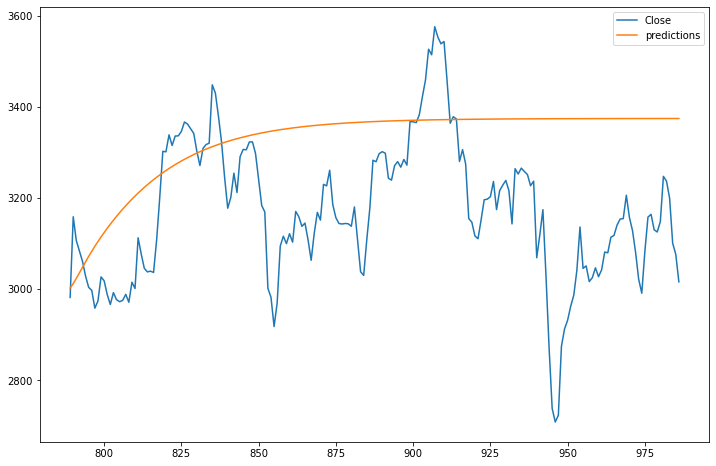

In [29]:
ASAIN_test.plot(figsize=(12,8))

In [30]:
forecast=[]
current_batch=scaled_train[-length:]
current_batch=current_batch.reshape((1,length,features))
for i in range(90):
    current_pred=model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
forecast=scaler.inverse_transform(forecast)

In [32]:
df_array=np.array(ASAIN_close)

full_data=pd.DataFrame(np.concatenate((df_array.flatten(),forecast.flatten())))

<AxesSubplot:>

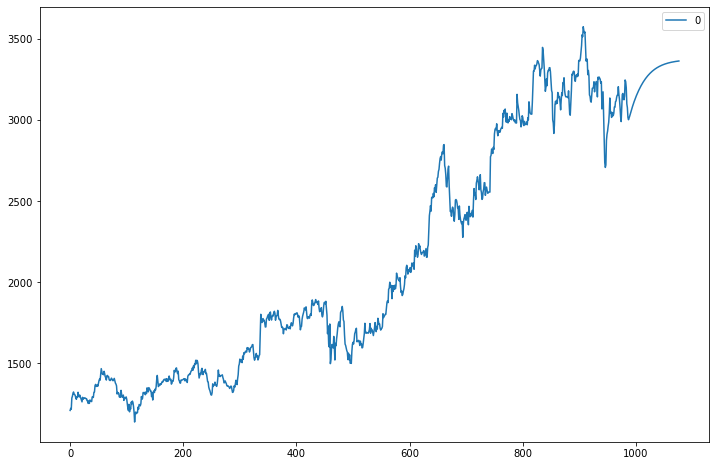

In [33]:
full_data.plot(figsize=(12,8))

In [34]:
# saving the model
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
from tensorflow.keras.models import load_model
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

ModuleNotFoundError: No module named 'keras'